<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install autorch > log.txt

In [3]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
df.head(3)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# 建立 f(case,input_wt,op) = output_wt

In [4]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']

  2%|▏         | 1/42 [00:00<00:33,  1.22it/s]

epoch:0 train_loss:0.0083 valid_loss:0.0012


100%|██████████| 42/42 [00:32<00:00,  1.29it/s]


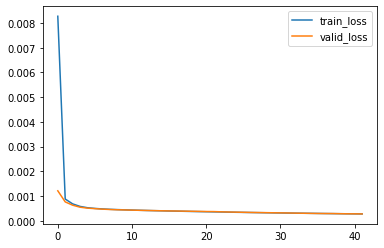

In [5]:
# train
c620_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=42,limit_y_range=True)
c620_f.train()

In [8]:
# test
x_test = c620_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c620_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
c620_f.show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.99697,3.73433e-05,0.216691
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.997171,0.00884335,0.163566
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.990075,0.00329226,0.103985
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997539,0.00251479,0.427317
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999995,1.43249e-08,0.0241523
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999995,2.64011e-09,0.0241526
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [14]:
def F(case,input_wt,op):
  sp = c620_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:21,  1.93it/s]

epoch:0 train_loss:0.0047 valid_loss:0.0004


100%|██████████| 42/42 [00:23<00:00,  1.80it/s]


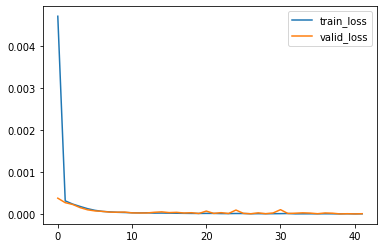

In [10]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.train()

In [11]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999982,2.67005e-11,0.000431486
Density_Vent Gas Production Rate and Composition,0.997564,5.26506e-08,0.0419875
Density_Distillate Production Rate and Composition,0.999447,5.70429e-08,0.0239558
Density_Sidedraw Production Rate and Composition,0.999843,1.7732e-10,0.00109278
Density_Bottoms Production Rate and Composition,0.999965,5.77942e-13,6.63569e-05
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.999668,0.044004,0.101531
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999748,0.000304774,0.103754
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999874,0.000211494,0.0738274
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999914,0.000113997,0.00471425
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.999926,5.87433e-05,0.00289304


In [15]:
cond = (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] >= 69) & (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] <= 71)
sample = df[cond].sample(1)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [16]:
sample[output_wt_col]

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [17]:
sample['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']

074-053    69.999969
Name: Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%, dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'  == 70

In [18]:
!pip install optuna > log.txt

In [19]:
sample[input_wt_col]

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
074-053,0.0,0.018298,0.443738,0.412712,0.12853,0.071674,0.014892,16.525988,0.007658,0.015105,0.0,0.012254,46.084351,0.008169,0.009616,0.009616,0.733654,5.038925,10.674893,4.729251,0.013955,0.011894,0.002638,0.014639,0.988117,0.517846,2.787771,0.290946,7.119931,0.0,1.136334,0.051236,0.000915,0.020128,0.763961,0.0,0.880156,0.322053,0.138153,0.0,0.0


In [20]:
sample[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
074-053,69.999969


In [21]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [24]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端bz = sample[case_col]['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%'][0]
  輸出端bz = F(sample[case_col],sample[input_wt_col],op)['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'].values[0]
  loss = (輸入端bz - 輸出端bz)**2
  
  return loss

In [25]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-04-19 06:52:15,112] A new study created in memory with name: no-name-9922bc9f-2347-49a3-9cb5-ec6b9a99c184
[I 2021-04-19 06:52:15,162] Trial 0 finished with value: 100.57624934314866 and parameters: {'Density_Feed Properties': 0.8642074078119354, 'Density_Vent Gas Production Rate and Composition': 0.4580013539767199, 'Density_Distillate Production Rate and Composition': 0.78146088046437, 'Density_Sidedraw Production Rate and Composition': 0.8807380016653344, 'Density_Bottoms Production Rate and Composition': 0.8720421115956567, 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 117.04251035971346, 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 14.491818064558498, 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 13.975890287273431, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 176.13008094915907, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 193

In [26]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
074-053,0.862257,0.44407,0.778065,0.879318,0.871962,109.561131,10.630034,12.544256,177.262501,194.179289


In [28]:
# 看有沒有符合業主需要的70
F(case,input_wt,op_opt)[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
074-053,69.999604


In [29]:
op_pred = G.predict(sample[case_col+input_wt_col])

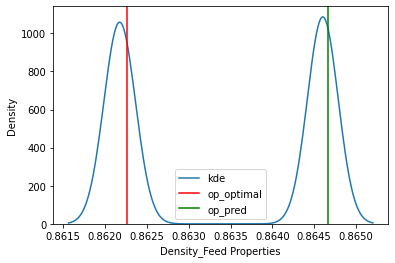

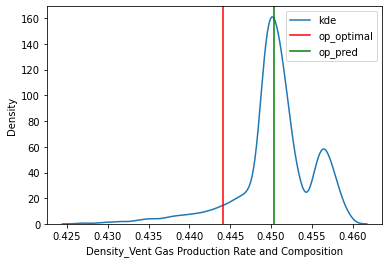

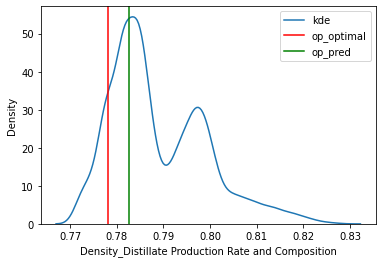

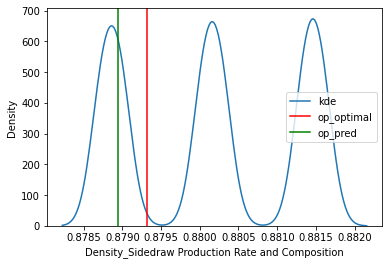

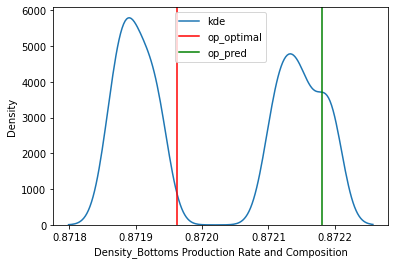

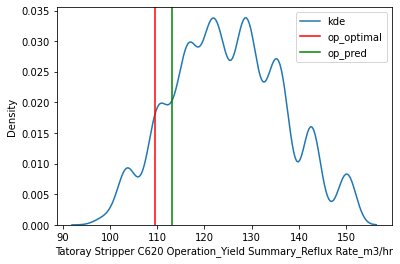

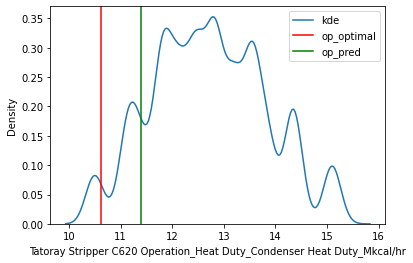

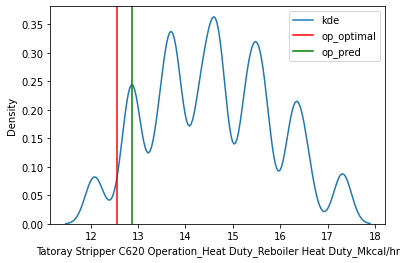

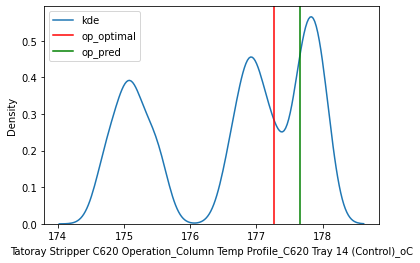

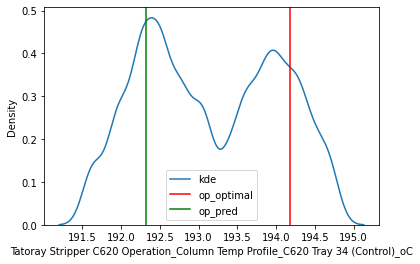

In [30]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [31]:
import joblib

joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')
joblib.dump(F,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl']